In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Part 2
## Task 7

In [2]:
Q = np.array(
    [[-0.0085, 0.005, 0.0025, 0.0, 0.001],
     [0.0, -0.014, 0.005, 0.004, 0.005],
     [0.0, 0.0, -0.008, 0.003, 0.005],
     [0.0, 0.0, 0.0, -0.009, 0.009],
     [0.0, 0.0, 0.0, 0.0, 0.00]]
)

assert np.allclose(Q.sum(axis=1), 0), "Rows of Q should sum to zero"

P = np.zeros_like(Q)
for i in range(Q.shape[0]):
    if Q[i, i] != 0:
        P[i] = Q[i] / -Q[i, i]
        P[i, i] = 0  # Set diagonal to zero

assert np.allclose(P[:-1].sum(axis=1), 1), "Rows of P should sum to one"

# extract negative diagonal elements for easier indexing
Q_s = Q[:-1, :-1]
q = -1 / np.diag(Q_s)

In [3]:
P, q

(array([[0.        , 0.58823529, 0.29411765, 0.        , 0.11764706],
        [0.        , 0.        , 0.35714286, 0.28571429, 0.35714286],
        [0.        , 0.        , 0.        , 0.375     , 0.625     ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([117.64705882,  71.42857143, 125.        , 111.11111111]))

In [4]:
# Sampling time until next transition from state 2
print(np.random.exponential(q[2]))

# Sampling next state from state 2
print(np.random.choice([0, 1, 2, 3, 4], p=P[2]))

43.34616937274432
3


In [5]:
def simulate_breast_cancer(womens: int):
    transitions = [[] for _ in range(womens)]  # Initialize transitions for each
    for woman in range(womens):
        state = 0
        t = 0.0
        while state < 4:
            time_to_next = np.random.exponential(q[state])
            next_state = np.random.choice(5, p=P[state])
            transitions[woman].append((t, state))

            t += time_to_next
            state = next_state
        transitions[woman].append((t, state))
    
    return transitions

np.random.seed(42)  # For reproducibility
results = simulate_breast_cancer(1000)

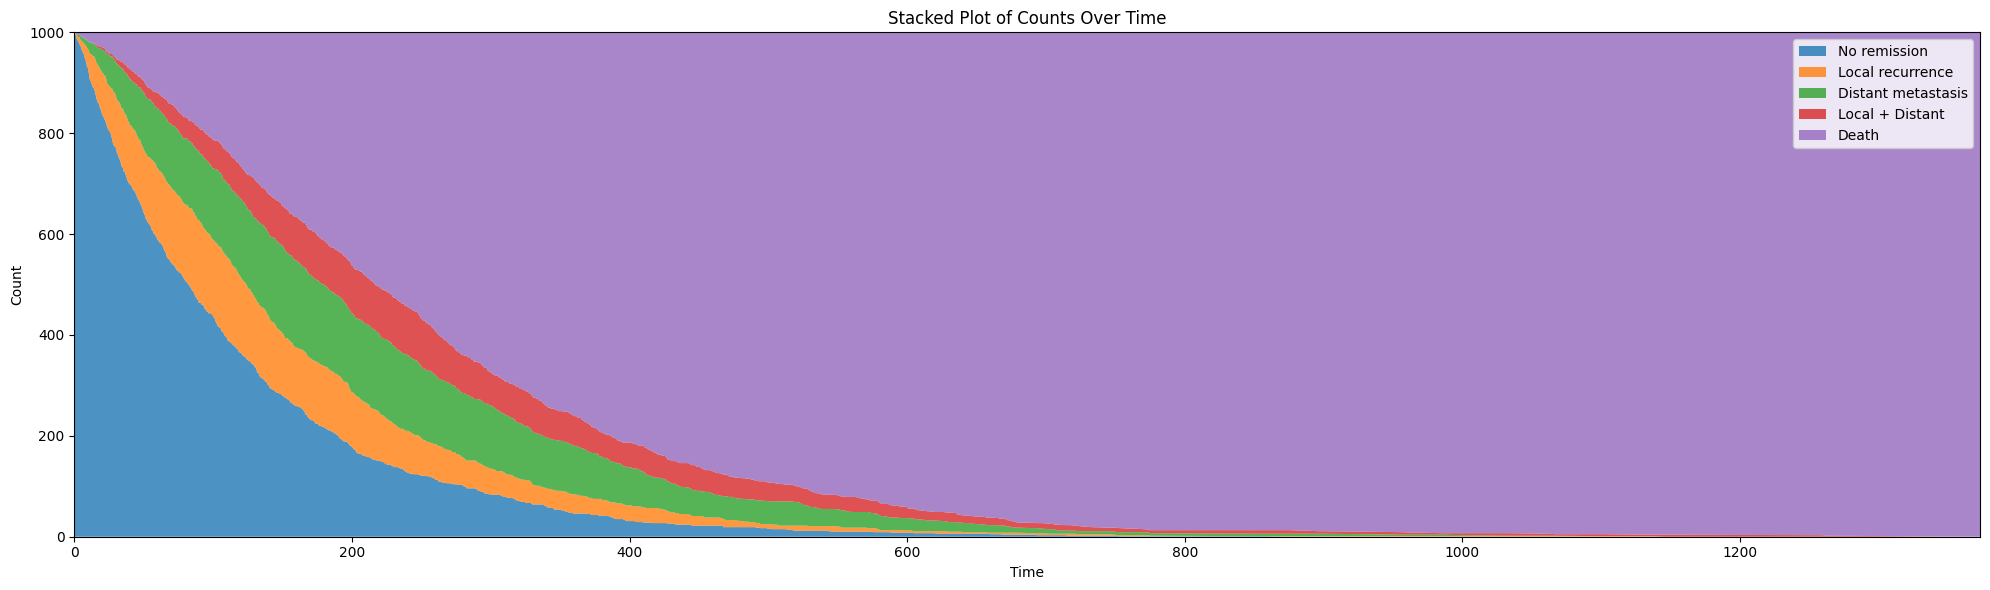

In [6]:
def construct_timeline(transitions):
    all_times = sorted({t for woman in transitions for (t, _) in woman})

    state_counts = np.zeros((len(all_times), 5), dtype=int)  # 5 states

    for woman in transitions:
        for i in range(len(woman) - 1):
            t_start, state = woman[i]
            t_end = woman[i+1][0]
            for j, t in enumerate(all_times):
                if t_start <= t < t_end:
                    state_counts[j, state] += 1
                    
        # For final absorbing state
        t_final, final_state = woman[-1]
        for j, t in enumerate(all_times):
            if t >= t_final:
                state_counts[j, final_state] += 1
    
    return np.array(all_times), state_counts

def plot_timeline(all_times, state_counts):
    labels = [
        "No remission",
        "Local recurrence",
        "Distant metastasis",
        "Local + Distant",
        "Death",
    ]
    
    plt.figure(figsize=(20, 6))
    plt.stackplot(all_times, state_counts.T, labels=labels, alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.title("Stacked Plot of Counts Over Time")
    plt.legend()
    plt.xlim(0, max(all_times))
    plt.ylim(0, 1000)
    plt.tight_layout()
    plt.show()

times, states = construct_timeline(results)
plot_timeline(times, states)
    

In [7]:
def report_lifetime_statistics(lifetimes, confidence=0.95):
    n = len(lifetimes)
    mean = np.mean(lifetimes)
    std = np.std(lifetimes, ddof=1)

    z = norm.ppf(1 - (1 - confidence) / 2)
    se_mean = std / np.sqrt(n)
    se_std = std / np.sqrt(2 * (n - 1))  # Approximate SE of sample std

    ci_mean = (mean - z * se_mean, mean + z * se_mean)
    ci_std = (std - z * se_std, std + z * se_std)

    print(f"Mean lifetime: {mean:.2f} (95% CI: {ci_mean[0]:.2f} – {ci_mean[1]:.2f})")
    print(f"Standard deviation: {std:.2f} (95% CI: {ci_std[0]:.2f} – {ci_std[1]:.2f})")

lifetimes = np.array([women[-1][0] for women in results])
report_lifetime_statistics(lifetimes, confidence=0.95)

Mean lifetime: 256.37 (95% CI: 244.32 – 268.42)
Standard deviation: 194.38 (95% CI: 185.86 – 202.90)


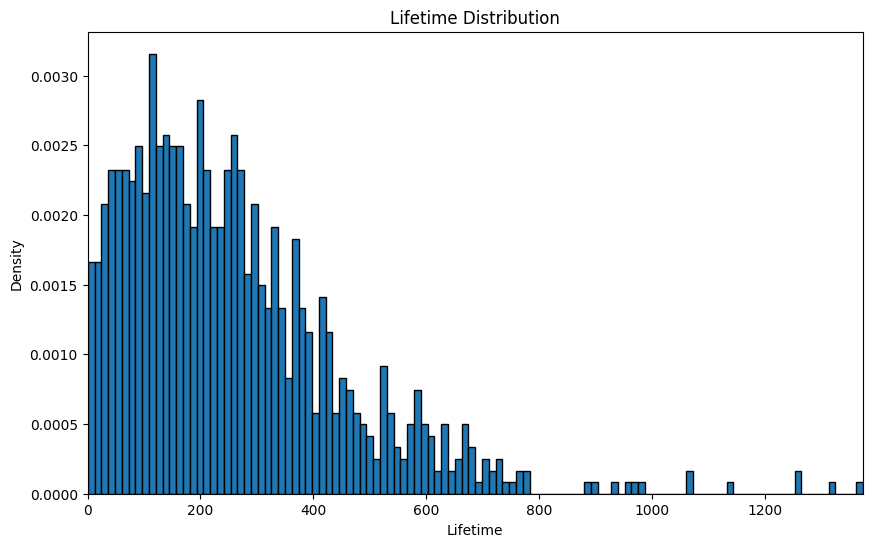

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(lifetimes, density=True, bins=int(np.max(lifetimes) // 12), edgecolor='black')
plt.xlim(0, np.max(lifetimes))
plt.title("Lifetime Distribution")
plt.xlabel("Lifetime")
plt.ylabel("Density");

In what proportion of women has the cancer reappeared distantly after 30.5 months?

I.e., what proportion are at state 2 or 3 immediately after 30.5 months?

In [9]:
# In what proportion of women has the cancer reappeared distantly after 30.5 months?
# What proportion of women visited state distant metastasis (or local + metastasis) from the beginning and up 30.5 months. 

# Iterate through women's transitions up to 30.5 and count how many visit state 2 or 3
count = 0
for women in results:
    for t, state in women:
        if t > 30.5:
            break
        if state in [2, 3]:
            count += 1
            break
        
print(f"Proportion of women with distant metastasis or local + distant metastasis after 30.5 months: {count / len(results):.3f}")

Proportion of women with distant metastasis or local + distant metastasis after 30.5 months: 0.084


## Task 8
Chi-square test is used. We need to decide the bins such that each entree is $\geq 5$. This is done by looking at the histogram of the data.

In [10]:
bin_edges = [100, 200, 400, 800, times[-1]]
bin_edges

[100, 200, 400, 800, 1372.8240864562467]

In [11]:
# Count number of deaths per 50 months
def count_deaths(times, states):
    death_counts = []
    last_count = 0

    for end_time in bin_edges:
        # Find index of first time after end_time
        t = np.searchsorted(times, end_time, side='left')
        try:
            count = states[t][-1]
        except IndexError:
            # If t is out of bounds, use the last known count
            count = states[-1][-1]
        death_counts.append(count - last_count)
        last_count = count

    return np.array(death_counts)

observed = count_deaths(times, states)
observed

array([213, 249, 352, 173,  13])

In [12]:
from scipy.linalg import expm

def theoritical_distribution(t):
    p_0 = np.array([1, 0, 0, 0])  # All start in state 0
    return 1 - p_0 @ expm(Q_s * t) @ np.ones(len(Q_s))  

def expect_deaths():
    death_counts = []
    last = 0.0
    for end_time in bin_edges:
        death_counts.append(np.round(1000 * (theoritical_distribution(end_time) - theoritical_distribution(last))))
        last = end_time
    return np.array(death_counts)


expected = expect_deaths()
expected

array([197., 254., 349., 183.,  16.])

In [13]:
from scipy.stats import chi2
def chi_squared_test(observed, expected):
    observed = np.array(observed)
    expected = np.array(expected)

    # Ensure the sums match (scale if needed)
    if not np.isclose(observed.sum(), expected.sum()):
        expected = expected * (observed.sum() / expected.sum())

    chi2_stat = np.sum((observed - expected) ** 2 / expected)

    # Degrees of freedom: (number of categories - 1)
    dof = len(observed) - 1

    # Compute p-value from chi2 statistic using survival function (1 - CDF)
    p_value = chi2.sf(chi2_stat, dof)

    return chi2_stat, p_value

chi_squared_test(observed, expected)

(2.529120982049247, 0.6394289320595818)

Make many runs to see if p-value is uniformly distributed

In [14]:
def run_experiment(num_runs=100):
    p_vals = []
    for _ in tqdm(range(num_runs), desc="Running experiments"):
        results = simulate_breast_cancer(1000)
        times, states = construct_timeline(results)
        observed = count_deaths(times, states)
        expected = expect_deaths()
        _, p_val = chi_squared_test(observed, expected)
        p_vals.append(p_val)
    
    return p_vals

p_vals = run_experiment(100)


Running experiments: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


Text(0, 0.5, 'Density')

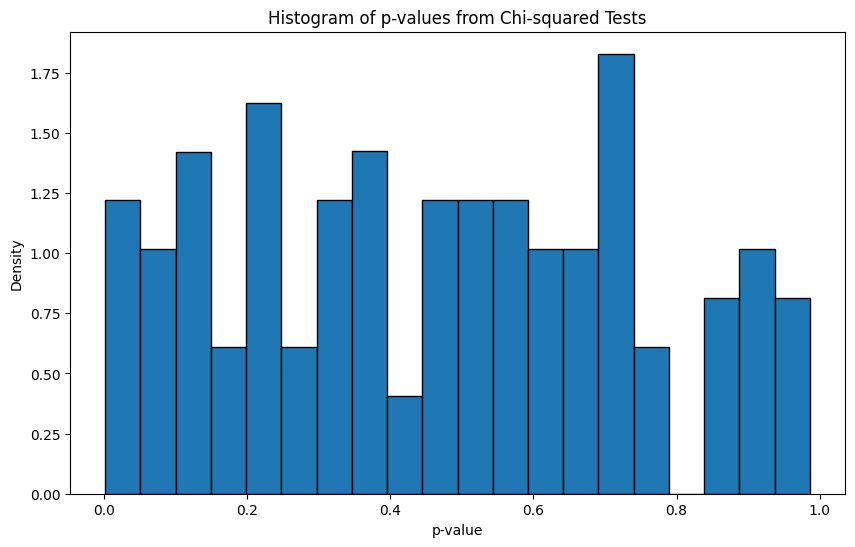

In [15]:
# plot histogram of p-values
plt.figure(figsize=(10, 6))
plt.hist(p_vals, bins=20, edgecolor='black', density=True)
plt.title("Histogram of p-values from Chi-squared Tests")
plt.xlabel("p-value")
plt.ylabel("Density")

## Task 9

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st

In [17]:
# ---------- 1.  Generator matrices (raw) --------------------
Q_base_raw = np.array([
    [-0.0085, 0.005 , 0.0025, 0.0  , 0.001],
    [ 0.0   ,-0.014 , 0.005 , 0.004, 0.005],
    [ 0.0   , 0.0   ,-0.008 , 0.003, 0.005],
    [ 0.0   , 0.0   , 0.0   ,-0.009, 0.009],
    [ 0.0   , 0.0   , 0.0   , 0.0  , 0.0  ]
], dtype=float)

Q_prev_raw = np.array([
    [ 0.0   , 0.0025, 0.00125, 0.0  , 0.001],
    [ 0.0   , 0.0   , 0.0    , 0.002, 0.005],
    [ 0.0   , 0.0   , 0.0    , 0.003, 0.005],
    [ 0.0   , 0.0   , 0.0    , 0.0  , 0.009],
    [ 0.0   , 0.0   , 0.0    , 0.0  , 0.0  ]
], dtype=float)

def penis(Q):
    """Force each row of Q to sum to 0"""
    Q = Q.copy()
    for i in range(Q.shape[0]):
        off_sum = Q[i].sum() - Q[i, i]
        Q[i, i] = -off_sum
    return Q

Q_base = penis(Q_base_raw)
Q_prev = penis(Q_prev_raw)


In [18]:
# ---------- 2.  Build P and leave rates ---------------------
def build_P_and_rates(Q):
    """Return (P, λ) even if some rows are absorbing (λ = 0)."""
    n = Q.shape[0]
    P = np.zeros_like(Q)
    lambdas = np.zeros(n)
    for i in range(n):
        off = Q[i].copy()
        off[i] = 0
        rate = off.sum()
        lambdas[i] = rate
        if rate > 0:
            P[i] = off / rate
    return P, lambdas


In [19]:
# ---------- 3.  Simulator: one woman at a time ---------------
def simulate_lifetimes(Q, n, seed=None):
    rng = np.random.default_rng(seed)
    P, rate = build_P_and_rates(Q)
    death = Q.shape[0] - 1
    lifetimes = np.empty(n)

    for idx in tqdm(range(n), desc="Simulating", leave=False):
        t, state = 0.0, 0
        while state != death:
            t    += rng.exponential(scale=1.0 / rate[state])
            state = rng.choice(P.shape[0], p=P[state])
        lifetimes[idx] = t
    return lifetimes


In [20]:
N = 1_000
base = simulate_lifetimes(Q_base, N, seed=69)
prev = simulate_lifetimes(Q_prev, N, seed=420)

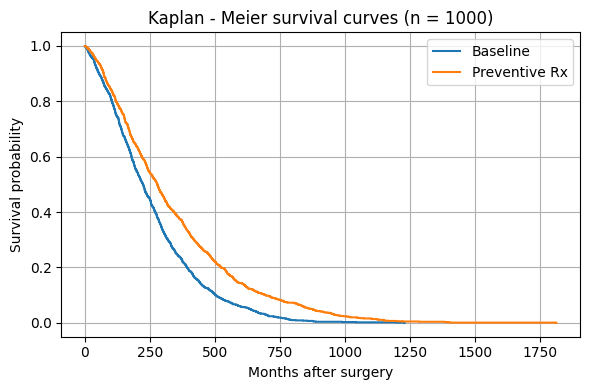

In [21]:
# ---------- 4.  Kaplan–Meier curve ---------------------------
def km_curve(times):
    times = np.sort(times)
    uniq  = np.unique(times)
    at_risk = len(times)
    surv = 1.0
    S = []
    for t in uniq:
        d = (times == t).sum()
        surv *= (1 - d / at_risk)
        S.append(surv)
        at_risk -= d
    return uniq, np.array(S)

t_base, S_base = km_curve(base)
t_prev, S_prev = km_curve(prev)

plt.figure(figsize=(6, 4))
plt.step(t_base, S_base, where="post", label="Baseline")
plt.step(t_prev, S_prev, where="post", label="Preventive Rx")
plt.xlabel("Months after surgery")
plt.ylabel("Survival probability")
plt.title(f"Kaplan - Meier survival curves (n = {N})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()  

# Task 10 (Optional) 

Does the preventitive treatment have a significant effect on the survival function? Answer the question using a log-rank test.

In [22]:
# ---------- 5.  Two-sample log-rank test ---------------------
def logrank(times_a, times_b):
    ts = np.unique(np.concatenate([times_a, times_b]))
    Oa = Ea = Va = 0.0
    for t in ts:
        da = (times_a == t).sum()
        db = (times_b == t).sum()
        d  = da + db
        ra = (times_a >= t).sum()
        rb = (times_b >= t).sum()
        r  = ra + rb
        if r <= 1 or d == 0:
            continue
        ea = d * ra / r
        va = d * (ra / r) * (1 - ra / r) * (r - d) / (r - 1)
        Oa += da
        Ea += ea
        Va += va
    chi2 = (Oa - Ea)**2 / Va if Va > 0 else 0.0
    pval = 1 - st.chi2.cdf(chi2, 1)
    return chi2, pval
chi2, p = logrank(base, prev)
print(f"Log-rank test: χ² = {chi2:.3f},  p-value = {p:.4g}")

Log-rank test: χ² = 69.450,  p-value = 1.11e-16


The treatment does have a statistically significant effect on survival. A positive one, based on the kaplan meier plot.

# Task 11

For the report, consider the following questions: What assumptions have
been eliminated, by going from the discrete to the continuous time model?
What have been added? How could the model be extended, such that the
sojourn times are Erlang distributed?


Switching from a discrete-time to a continuous-time model removes the assumption that transitions can only occur at fixed time intervals, allowing events to happen at any point in time and making the model more realistic. However, it introduces the assumption that sojourn times are exponentially distributed, which implies memorylessness and may not always reflect real-world behavior. The model also assumes a Markov process, where future transitions depend only on the current state. To allow more realistic time-in-state distributions, such as Erlang distributions, each state can be split into multiple sequential substates with exponential transitions, effectively shaping the total sojourn time without losing the Markov property.